In [1]:
#install.packages("emmeans")
library(DHARMa)
library(lindia)
library(tidyverse)
library(caret)
library(leaps)
library(MASS)
library(modEvA)
library(dplyr)
library(lme4) #random effect
library(broom)
library(ggpubr) 
library(rstatix)
library(WRS2) #robust ancova
library(lmerTest) #like lmer but with p-value
library(emmeans) #visualize interaction term

#levenetest
library(car)

library(rstanarm) #r2 in mixed effect models
library(performance) #r2 in mixed effect models

This is DHARMa 0.3.3.0. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa') Note: Syntax of plotResiduals has changed in 0.3.0, see ?plotResiduals for details

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.3
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':



In [183]:
citation("DHARMa")


To cite package 'DHARMa' in publications use:

  Florian Hartig (2020). DHARMa: Residual Diagnostics for Hierarchical
  (Multi-Level / Mixed) Regression Models. R package version 0.3.3.0.
  https://CRAN.R-project.org/package=DHARMa

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {DHARMa: Residual Diagnostics for Hierarchical (Multi-Level / Mixed)
Regression Models},
    author = {Florian Hartig},
    year = {2020},
    note = {R package version 0.3.3.0},
    url = {https://CRAN.R-project.org/package=DHARMa},
  }


# Download data

In [40]:
#path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/chapter0_final_/visual/Treatment&Classs/adaptability/chapter0_final__percentgaeHensNotMovingTreatment.csv'
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/correctlightschedule_/visual/Treatment&Classs/adaptability'
df = read.csv(file.path(path_,'STATInterIntraDifferences.csv'), header = TRUE, sep = ";")
#df = read.csv(file.path(path_,'STATpercentgaeHensNotMovingTreatmentPenmonth1.csv'), header = TRUE, sep = ";")
#df$SQRTPercentagenotmoving <- sqrt(df$Percentagenotmoving)
df$Treatment = as.factor(df$Treatment) 
df$PenID = as.factor(df$PenID)
df$henID1 = as.factor(df$henID1)
df$henID2 = as.factor(df$henID2)
df$inter_intra = as.factor(df$inter_intra)
df$DIB = as.integer(df$DIB) #as factor as within a week its not th etime taht we want to take into acount, but the event
df$HenID1_CLASS = as.factor(df$HenID1_CLASS)
df$HenID2_CLASS = as.factor(df$HenID2_CLASS)
df$sqrtchi2distance = sqrt(df$chi2distance)
name = 'firsttry'
print(dim(df))
summary(df)
head(df, 3)

[1] 11918    46


       X              DIB             DOA        Treatment       henID1     
 Min.   :    0   Min.   : 1.00   Min.   :119.0   OFH :5810   hen_10 :   96  
 1st Qu.: 2979   1st Qu.:19.00   1st Qu.:137.0   TRAN:6108   hen_108:   96  
 Median : 5958   Median :30.00   Median :148.0               hen_111:   96  
 Mean   : 5958   Mean   :29.72   Mean   :147.7               hen_112:   96  
 3rd Qu.: 8938   3rd Qu.:42.00   3rd Qu.:160.0               hen_117:   96  
 Max.   :11917   Max.   :53.00   Max.   :171.0               hen_118:   96  
                                                             (Other):11342  
     henID2      inter_intra      PenID      HenID1_CLASS HenID2_CLASS
 hen_118:  108   inter:5959   pen10  :1728   LEXP :2336   LEXP :2283  
 hen_69 :  107   intra:5959   pen11  :1728   MEXP :3334   MEXP :3399  
 hen_9  :  107                pen12  :1516   Other:6248   Other:6236  
 hen_143:  106                pen8   :1472                            
 hen_99 :  106               

,X,DIB,DOA,Treatment,henID1,henID2,inter_intra,PenID,HenID1_CLASS,HenID2_CLASS,...,max_nbr_stays_5_Zone,min_nbr_stays_2_Zone,max_nbr_stays_2_Zone,min_nbr_stays_1_Zone,max_nbr_stays_1_Zone,min_nbr_stays_5_Zone_cat,max_nbr_stays_5_Zone_cat,X5_Zone_is_samerange,is_only_other,sqrtchi2distance
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0,1,119,OFH,hen_102,hen_102,intra,pen3,MEXP,MEXP,...,2,0,2,0,0,0-4,0-4,True,False,0.3591534
2,1,1,119,OFH,hen_104,hen_102,inter,pen3,Other,MEXP,...,3,0,4,0,0,0-4,0-4,True,False,0.4711644
3,2,1,119,OFH,hen_102,hen_94,inter,pen3,MEXP,LEXP,...,2,0,2,0,0,0-4,0-4,True,False,0.3591534


# Mixed effect models

In [ ]:
Both DIB and inter_intra are important, but the contribution of DIB depends on the level of inter_intra

In [27]:
all(is.na(df$min_nbr_stays_5_Zone))

[1] FALSE

In [86]:
#with only non mexp
#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_5_Zone ~ min_nbr_stays_5_Zone + max_nbr_stays_5_Zone + DIB + inter_intra + DIB*inter_intra + Treatment + (1|PenID/henID1) + (1|factor(DIB)), 
           data=df_NOMEXP)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: DTW_15_5_Zone ~ min_nbr_stays_5_Zone + max_nbr_stays_5_Zone +  
    DIB + inter_intra + DIB * inter_intra + Treatment + (1 |  
    PenID/henID1) + (1 | factor(DIB))
   Data: df_NOMEXP

REML criterion at convergence: 45706.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7834 -0.7410 -0.1003  0.7813  2.9507 

Random effects:
 Groups       Name        Variance Std.Dev.
 henID1:PenID (Intercept)  48.777   6.984  
 factor(DIB)  (Intercept)   9.941   3.153  
 PenID        (Intercept)  10.185   3.191  
 Residual                 996.076  31.561  
Number of obs: 4678, groups:  henID1:PenID, 69; factor(DIB), 50; PenID, 8

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           7.462e+01  3.001e+00  2.496e+01  24.868  < 2e-16 ***
min_nbr_stays_5_Zone -1.652e+00  2.591e-01  4.644e+03  -6.375 2.01e-10 ***
max_nbr_stays_5_Zone  1.465

In [96]:
#rand: Likelihood Ratio Test On Random Effects Of Linear Mixed Effects Model
#tests the hypothesis that the random effect variation is significant versus the null that there is no between group-level 
#variation
rand(fit)

boundary (singular) fit: see ?isSingular

Warning message:
"Model failed to converge with 1 negative eigenvalue: -7.7e+02"


,npar,logLik,AIC,LRT,Df,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,13,-58163.24,116352.5,NA,NA,NA
(1 | henID1:PenID),12,-58255.93,116535.9,185.3880798,1,3.229069e-42
(1 | PenID),12,-58166.06,116356.1,5.6441181,1,1.751402e-02
(1 | factor(DIB)),12,-58175.23,116374.5,23.9744922,1,9.762049e-07
(1 | HenID1_CLASS),12,-58163.41,116350.8,0.3468148,1,5.559218e-01
(1 | HenID2_CLASS),12,-58165.60,116355.2,4.7294294,1,2.965072e-02


In [97]:
#ranef(fit)

In [98]:
#confint(fit)

# Assumptions for lmer

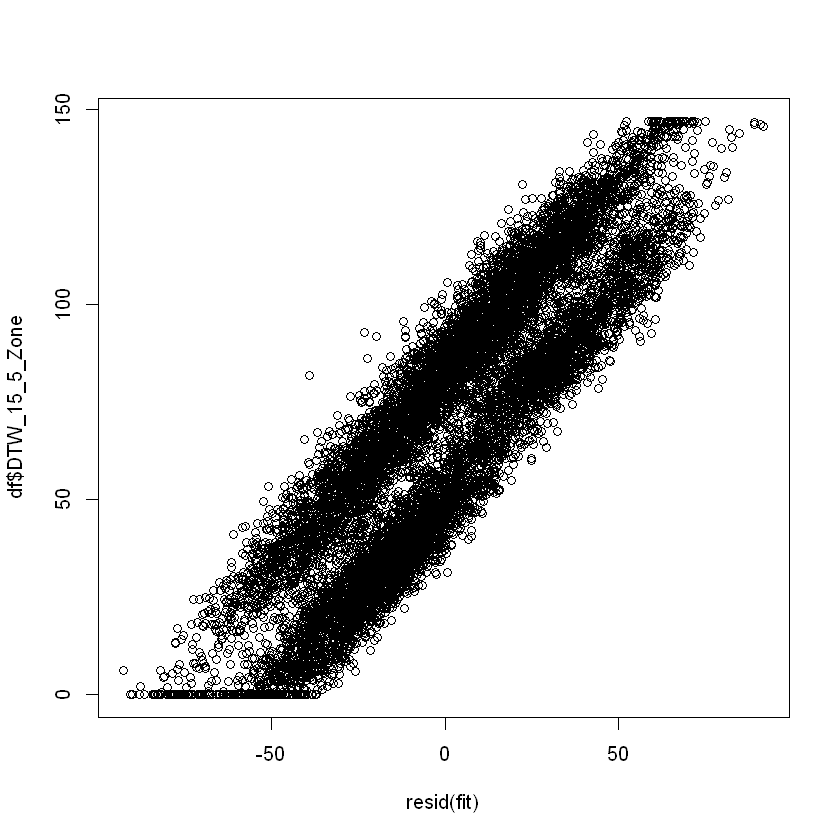

In [100]:
#linearity of predictors: plot residual vs observed
#jpeg(file.path(path_, paste('diagnostic_plot_linearity_',name,'.jpg', sep='')))
plot(resid(fit),df$DTW_15_5_Zone)
#dev.off()

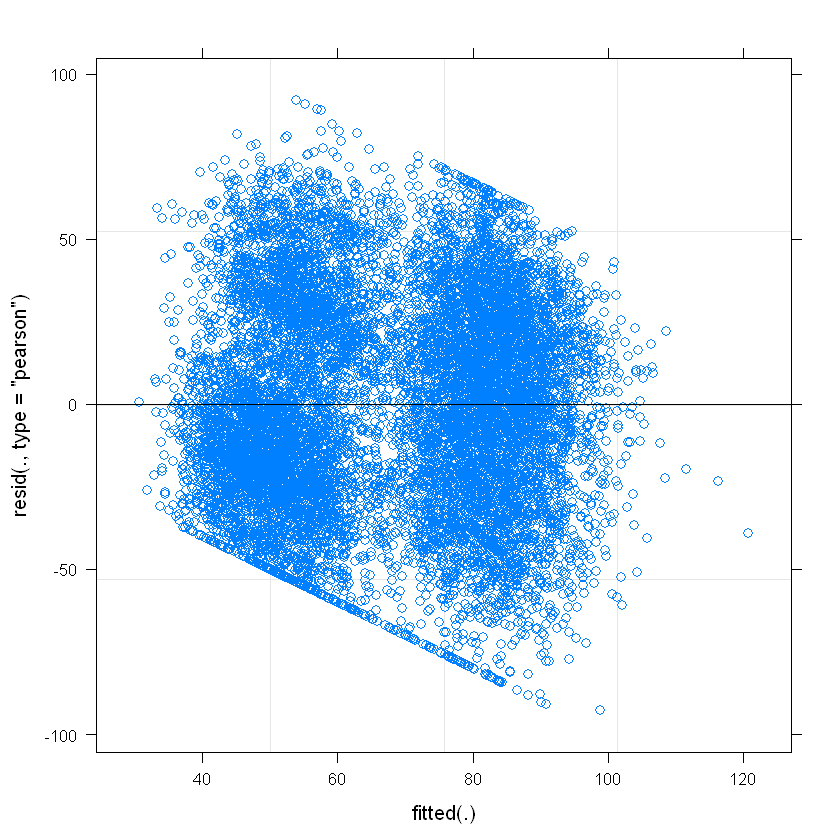

In [101]:
#check homogeneity of variance (residuals has constant variance)
#variance of the residuals is equal across groups
plot(fit)
#There seems to be even spread around the centered line

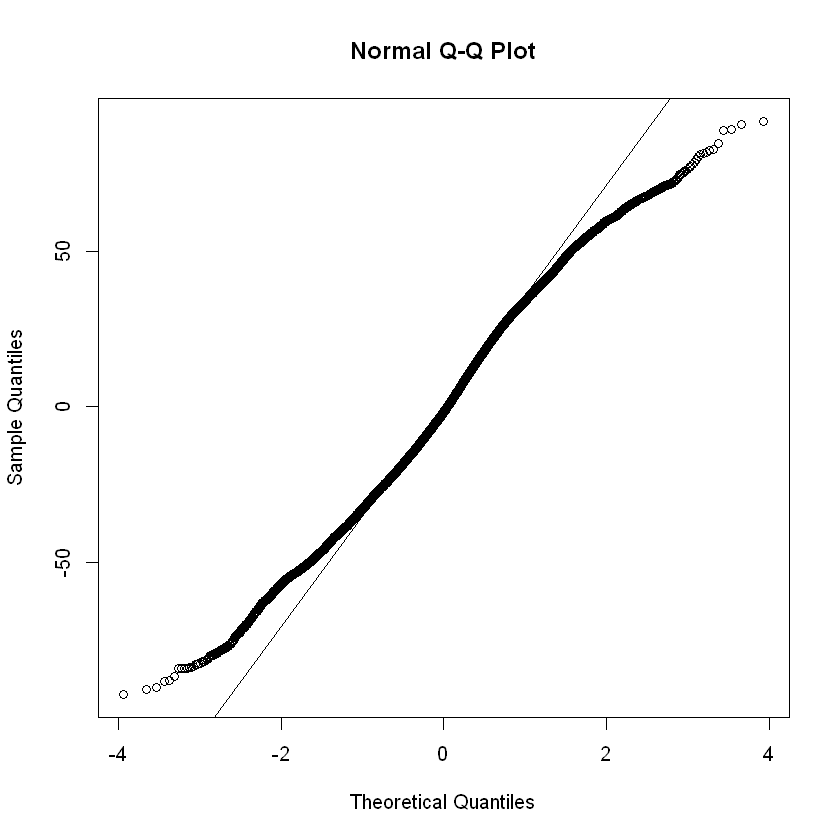

In [102]:
#normally distributed residuals
#qqmath(fit) #same
qqnorm(resid(fit))
qqline(resid(fit))

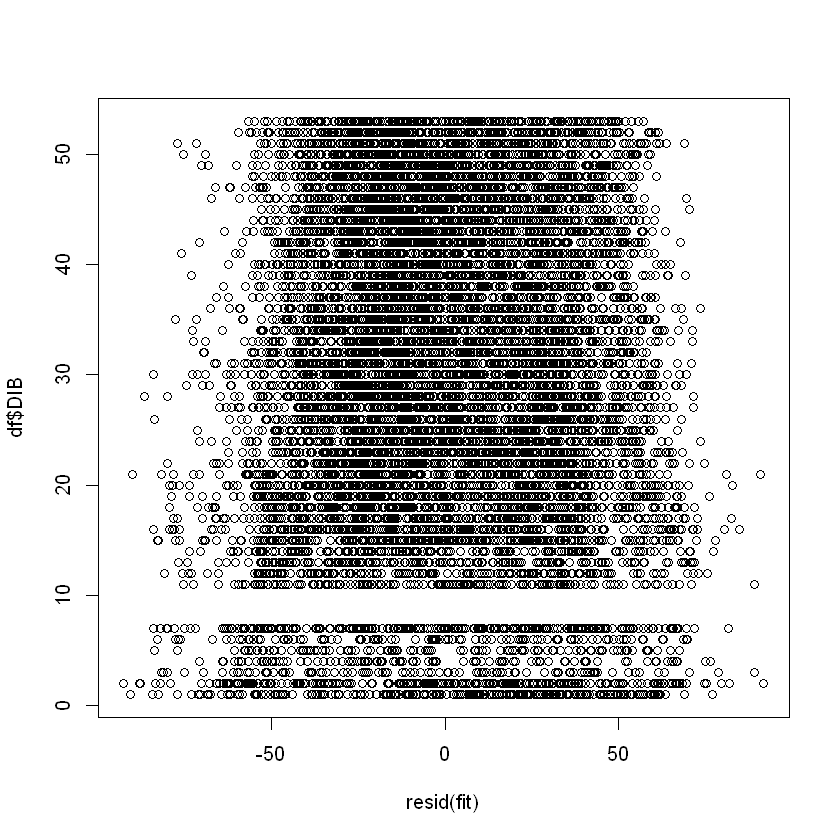

In [132]:
#The residuals are independent. This can be checked by plotting residuals against covariates - especially time-varying or spatial covariates. There should not be any systematic pattern
plot(resid(fit),df$DIB)

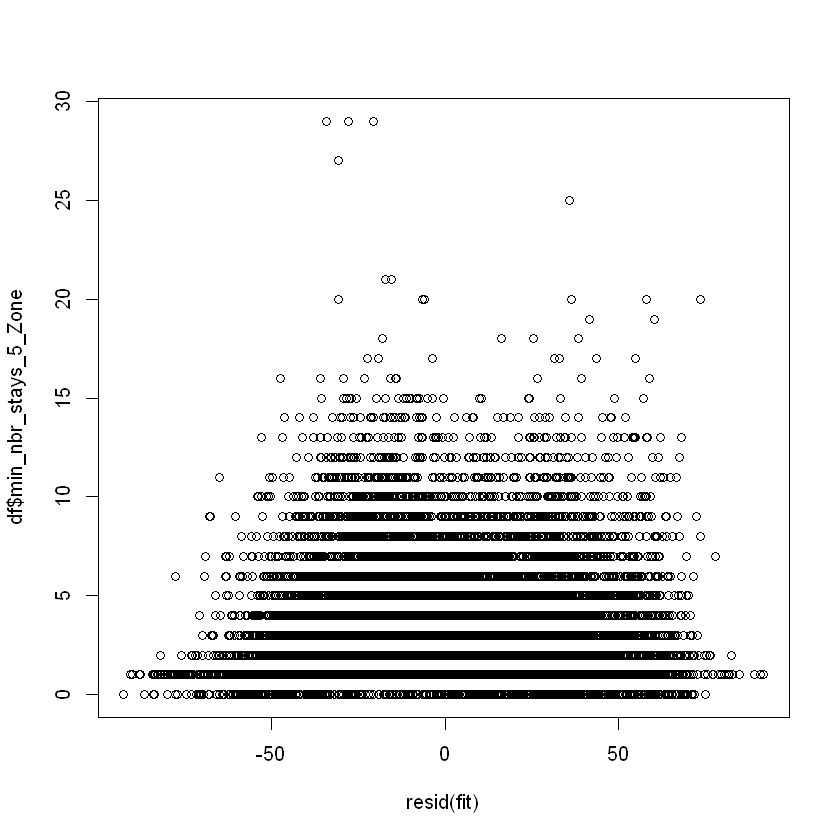

In [131]:
plot(resid(fit),df$min_nbr_stays_5_Zone)

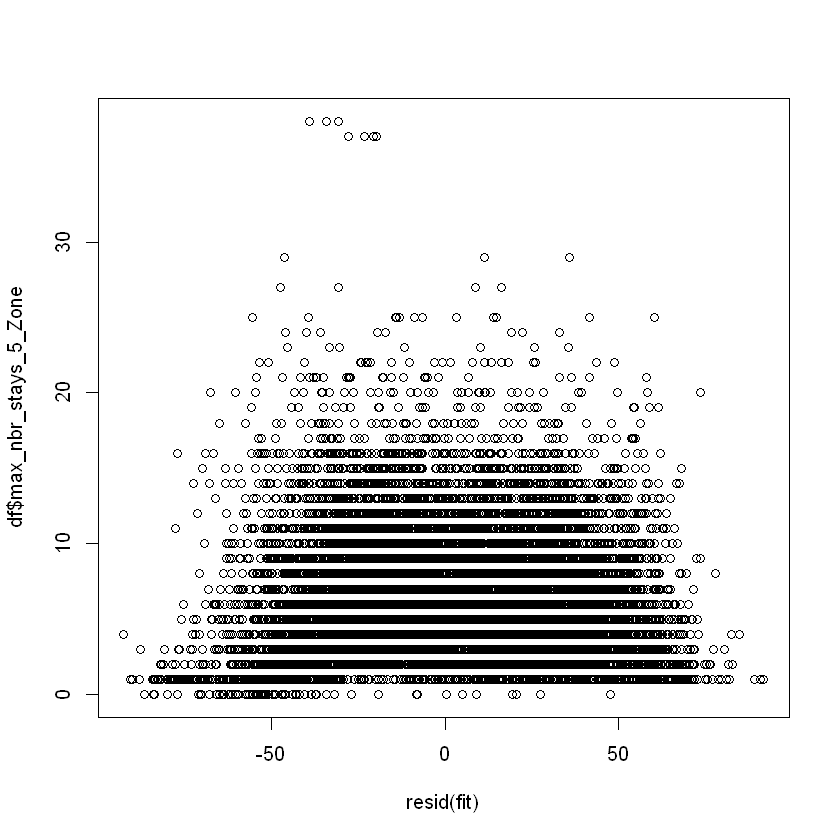

In [130]:
plot(resid(fit),df$max_nbr_stays_5_Zone)

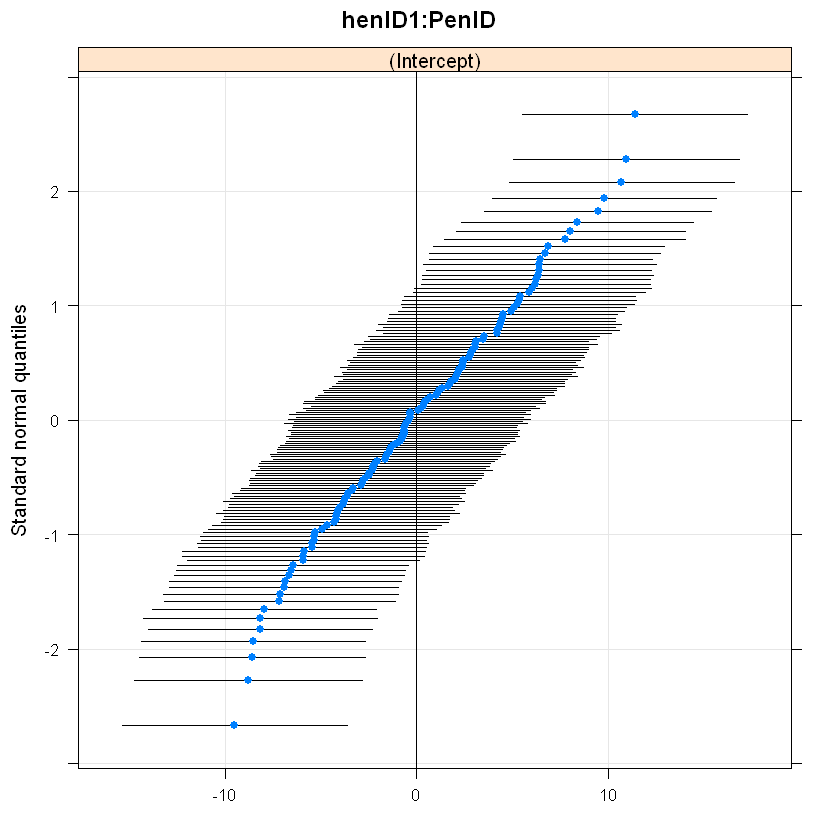

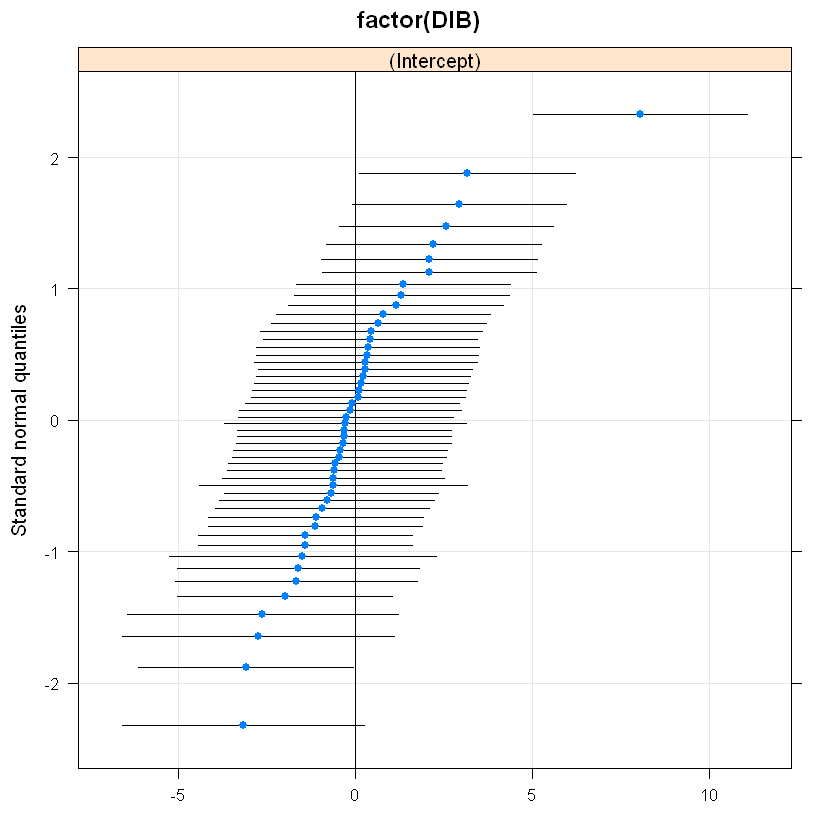

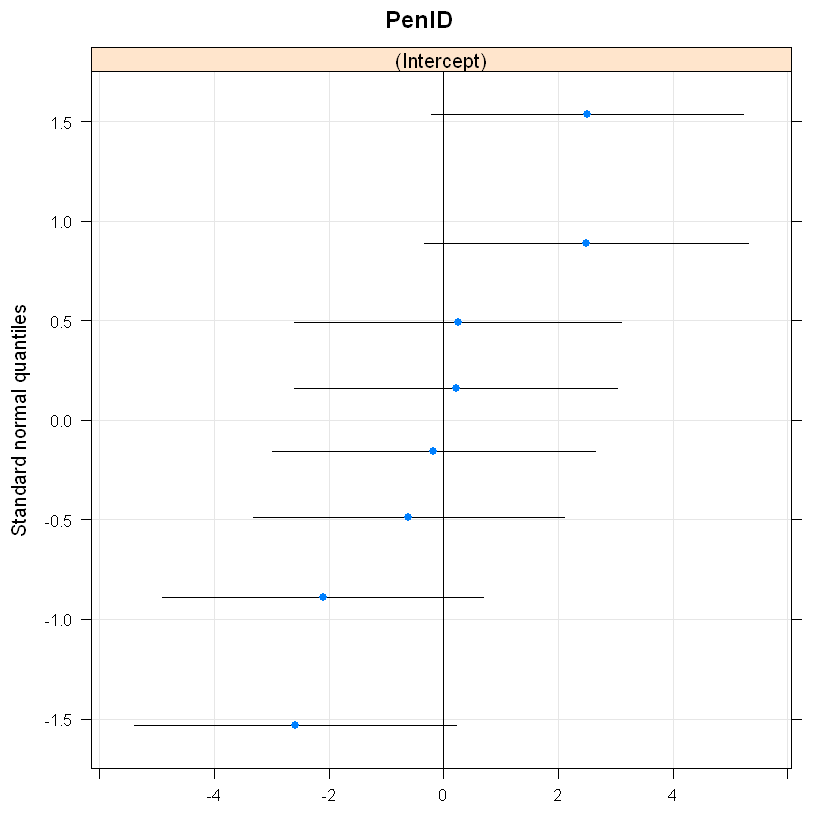

$`henID1:PenID`

$`factor(DIB)`

$PenID

$HenID2_CLASS

$HenID1_CLASS


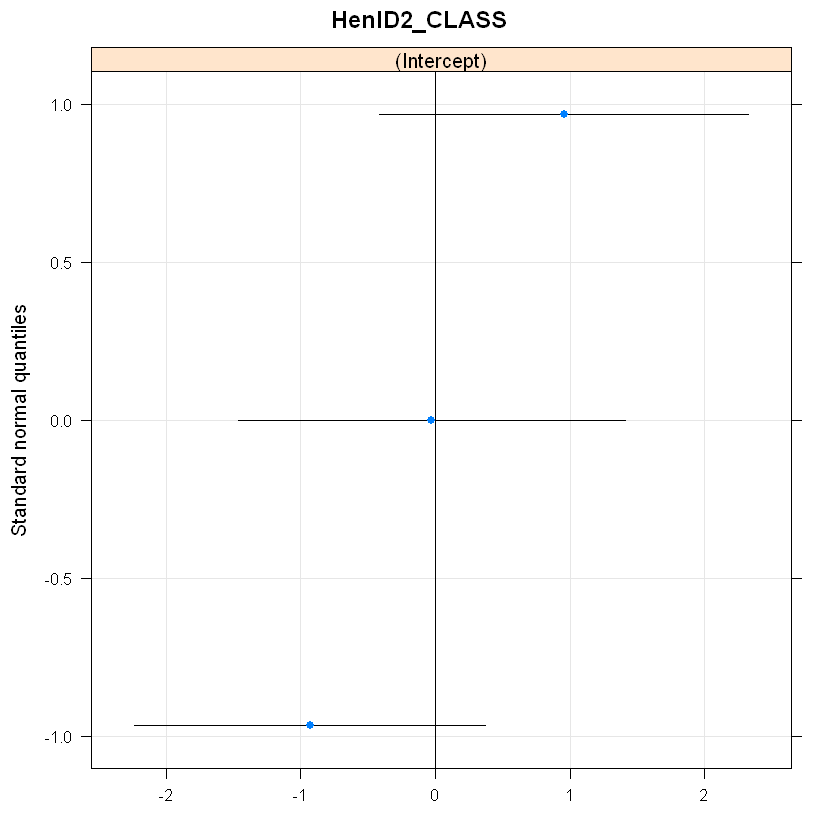

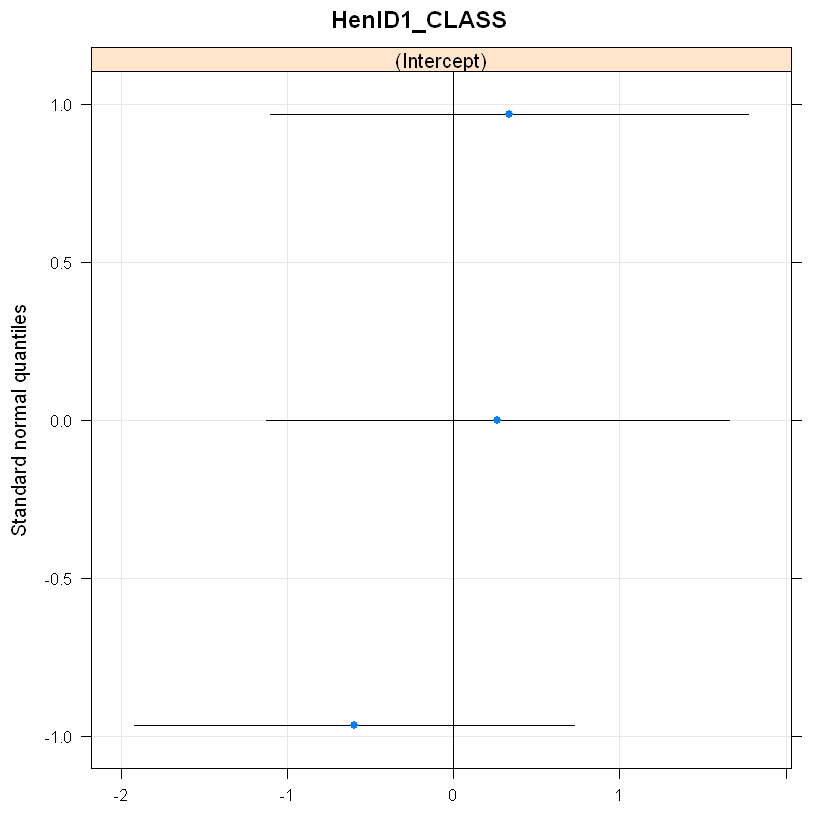

In [103]:
#qqplot
qqmath(ranef(fit))